In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE

In [7]:
#Import data credit Kyle Skom https://github.com/kyleskom/NBA-Machine-Learning-Sports-Betting/tree/master/Personal_Tests
data = pd.read_excel('DataSet21-22.xlsx', index_col=0)
#filter data for games in which home team plays over 20 games
data = data.query("GP >= 20")


In [8]:
#drop unneeded results based columns
data = data.drop(['OU', "Date", 'Date.1','Score', 'OU-Cover', 'Date'], axis=1)
#drop team name for reproducability for 2022 season
data = data.drop(['TEAM_NAME','TEAM_NAME away'], axis=1)

data.head

<bound method NDFrame.head of        GP   W   L  W_PCT   MIN   FGM   FGA  FG_PCT  FG3M  FG3A  ...  \
250    20  16   4  0.800  48.5  37.2  79.8   0.466   9.3  26.1  ...   
263    20  12   8  0.600  48.3  36.6  79.6   0.460   5.7  17.1  ...   
265    20  12   8  0.600  48.0  38.8  84.5   0.459   6.7  19.2  ...   
266    20  10  10  0.500  48.3  37.9  83.3   0.454   8.6  19.6  ...   
270    20  13   7  0.650  48.8  36.3  82.4   0.440   7.6  19.8  ...   
...    ..  ..  ..    ...   ...   ...   ...     ...   ...   ...  ...   
18838  82  53  29  0.646  48.1  40.5  86.4   0.469  14.3  39.4  ...   
18839  82  51  31  0.622  48.5  40.7  87.4   0.466  13.2  37.1  ...   
18840  82  51  31  0.622  48.5  40.7  87.4   0.466  13.2  37.1  ...   
18841  82  53  29  0.646  48.1  40.5  86.4   0.469  14.3  39.4  ...   
18842  82  51  31  0.622  48.5  40.7  87.4   0.466  13.2  37.1  ...   

       AST_RANK away  TOV_RANK away  STL_RANK away  BLK_RANK away  \
250               10             21             

In [28]:
#split data into training and testing models
X = np.array(data.drop(['Home-Team-Win'], axis=1).values,  dtype=np.float32)
y = np.array(data['Home-Team-Win'].values,  dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.unsqueeze(torch.FloatTensor(y_train), dim=1)
y_test = torch.FloatTensor(y_test)

#verify data is stratified across y
print(sum(y_test)/len(y_test))
print(sum(y_train)/len(y_train))


tensor(0.5889)
tensor([0.5889])


In [29]:
#X_train.shape
y_train.shape
#y_test.shape
#X_test.shape

torch.Size([11715, 1])

In [68]:
#define model
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,104)
        self.fc2 = nn.Linear(104,104)
        self.fc3 = nn.Linear(104,104)
        self.fc4 = nn.Linear(104,104)
        self.fc5 = nn.Linear(104,104)
        self.fc6 = nn.Linear(104,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        return x

#hyper parameters
learning_rate = 0.005
epochs = 1000
# Model , Optimizer, Loss
model = Net(input_shape=104)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
criterion = nn.BCELoss()


In [69]:
#forward loop
loss_arr = []
for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.6913092732429504
Epoch: 10 Loss: 0.6832159757614136
Epoch: 20 Loss: 0.6795579791069031
Epoch: 30 Loss: 0.6777061820030212
Epoch: 40 Loss: 0.6765464544296265
Epoch: 50 Loss: 0.6756570935249329
Epoch: 60 Loss: 0.6748924851417542
Epoch: 70 Loss: 0.6741859316825867
Epoch: 80 Loss: 0.6735073328018188
Epoch: 90 Loss: 0.6728463768959045
Epoch: 100 Loss: 0.6721985936164856
Epoch: 110 Loss: 0.6715518832206726
Epoch: 120 Loss: 0.6709011197090149
Epoch: 130 Loss: 0.6702411770820618
Epoch: 140 Loss: 0.6695694923400879
Epoch: 150 Loss: 0.668881893157959
Epoch: 160 Loss: 0.6681744456291199
Epoch: 170 Loss: 0.6674456596374512
Epoch: 180 Loss: 0.6666857004165649
Epoch: 190 Loss: 0.6658941507339478
Epoch: 200 Loss: 0.6650687456130981
Epoch: 210 Loss: 0.6641935706138611
Epoch: 220 Loss: 0.6632634401321411
Epoch: 230 Loss: 0.6622779965400696
Epoch: 240 Loss: 0.6612308025360107
Epoch: 250 Loss: 0.660128116607666
Epoch: 260 Loss: 0.6589842438697815
Epoch: 270 Loss: 0.6578130722045898
Epoch

In [65]:
# view weights
for param in model.parameters():
    print(param.data)

tensor([[-0.0540,  0.0246,  0.0354,  ...,  0.0683, -0.0263, -0.0353],
        [-0.0538,  0.0678, -0.0596,  ...,  0.0309, -0.0920, -0.0419],
        [ 0.0765,  0.0521, -0.0030,  ..., -0.0010, -0.0809,  0.0754],
        ...,
        [-0.0307, -0.0288, -0.0932,  ...,  0.0515,  0.0882,  0.0878],
        [-0.0886, -0.0644,  0.0790,  ..., -0.0821,  0.0726, -0.0076],
        [ 0.0677,  0.0770,  0.0025,  ..., -0.0977,  0.0362,  0.0662]])
tensor([-0.0522,  0.0802,  0.0167, -0.0661, -0.0333,  0.0848,  0.0684, -0.0266,
         0.0197,  0.0975, -0.0479,  0.0086, -0.0392, -0.0508, -0.0606, -0.0862,
         0.0184, -0.0837,  0.0090, -0.0768,  0.0472, -0.0869, -0.0232, -0.0260,
        -0.0716, -0.0535,  0.0392,  0.0357, -0.0743,  0.0798,  0.0890, -0.0187,
        -0.0862, -0.0891, -0.0627,  0.0096,  0.0129,  0.0227,  0.0965, -0.0517,
        -0.0639, -0.0383, -0.0579, -0.0209, -0.0775,  0.0293, -0.0440,  0.0626,
        -0.0543,  0.0589, -0.0797,  0.0232,  0.0833, -0.0489,  0.0813, -0.0938,
      

In [70]:
#test model
preds =[]
for i, x in enumerate(X_test):

    model.eval()
    with torch.no_grad():
        y_hat = model(x)
    preds.append(float(y_hat))


In [71]:
#Model Eval
#Calculate MAE
mae = MAE(y_test, preds)
print(mae)

#Calculate Misclassification
rounded_preds = np.round(preds, 0)
y_test = np.array(y_test)
missclass = []

for i in range(0,len(rounded_preds)):
    if y_test[i] == rounded_preds[i]:
        missclass.append(0)
    else:
        missclass.append(1)

missclass_rate = sum(missclass)/len(missclass)
print(f'misclassification: {missclass_rate}')

0.4203539634318676
misclassification: 0.3308296346876067


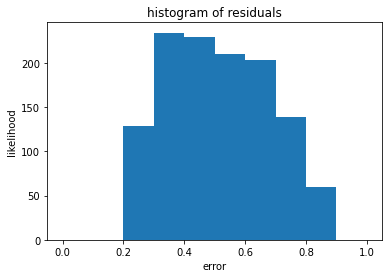

In [73]:
#residuals
residuals = np.subtract(preds, y_test)
residuals
fig,ax = plt.subplots(1,1)
a = np.array(residuals)
ax.hist(a, bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_title("histogram of residuals")
ax.set_xlabel('error')
ax.set_ylabel('likelihood')
plt.show()


In [75]:
#save model

0.20952516794204712